# Notebook to Segment Skeletal Muscle Area from MRI images (TIFs)

###### Load libraries and directories

In [1]:
import os
os.getcwd()
os.chdir('/tf/smipipeline')
print(os.getcwd())

/tf/smipipeline


In [2]:
from IPython.display import display, HTML

In [3]:
# from IPython import get_ipython
from tqdm.notebook import tqdm
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=1)

# Custom modules for debugging
from SliceViewer import ImageSliceViewer3D, ImageSliceViewer3D_1view,ImageSliceViewer3D_2views
from investigate import *

#pd.set_option("display.max_rows", 10)
      
import json
from run_sma_experiment import find_l3_images,output_images
import pprint
from L3_finder import *

# Custom functions
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):        
    with open(filename, 'rb') as input:
        return pickle.load(input)

Using TensorFlow backend.


In [4]:
import csv
import sys
from collections import defaultdict
from pathlib import Path
import tables

In [5]:
get_ipython().run_line_magic('tb', '')

No traceback available to show.


In [6]:
cwd = os.getcwd()
print(cwd)
data = '/tf/data'
pickles = '/tf/pickles'
models = '/tf/models'

/tf/smipipeline


In [7]:
# Import modules and config file
configfile = os.path.join(cwd,'config/mri/sma_mri_retrain.json')
with open(configfile, "r") as f:
        config = json.load(f)
pp.pprint(config)

{'CPU': 8,
 'GPU': 1,
 'all_modalities': ['MR'],
 'batch_size': 4,
 'data_file': '/tf/data/sarcopeniaMR_L3_h5/mri.h5',
 'data_split': [0.7, 0.1, 0.2],
 'image_masks': ['truth'],
 'image_shape': [256, 256],
 'input_shape': [1, 256, 256],
 'input_type': 'Image',
 'labels': ['1'],
 'monitor': 'output',
 'n_channels': 1,
 'n_epochs': 100,
 'n_labels': 1,
 'output_dir': '/tf/models/muscle/mri/',
 'overwrite': 1,
 'problem_type': 'Segmentation',
 'show_plots': False,
 'skip_blank': False,
 'testing_split': '/tf/pickles/mri/test_0.2.pkl',
 'training_modalities': ['MR'],
 'training_model_name': 'ct_mri_invert_retrain.h5',
 'training_split': '/tf/pickles/mri/train_0.7.pkl',
 'transfer_learning_model': '/tf/models/muscle/cv_final/combined_2020-02-18_dice_fold_0.h5',
 'validation_split': '/tf/pickles/mri/validation_0.1.pkl'}


### Segment L3 Axial Images and Calculate Muscle Area

In [8]:
# debug
#with open(f'/tf/smipipeline/config/mri/sma_mri_retrain.json', "w") as outfile:
#    json.dump(config, outfile)

In [9]:
# Import functions from run_training.py
# The cells below will also be based on code in run_training.py
from run_training import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
# Step 1: Check if training type is defined
try:
    input_type = config["input_type"]
except:
    raise Exception("Error: Input type not defined | \t Set  config[\"input_type\"] to \"Image\", \"Clinical\" or \"Both\" \n")

try:
    problem_type = config["problem_type"]
except:
    raise Exception("Error: Problem type not defined | \t Set  config[\"problem_type\"] to \"Classification\", \"Segmentation\" or \"Regression\" \n")

In [11]:
print(config['data_file'])

/tf/data/sarcopeniaMR_L3_h5/mri.h5


In [12]:
# Step 2: Check if the Data File is defined and open it
try:
    data_file = tables.open_file(config["data_file"], mode='r')
except:
    raise Exception("Error: Could not open data file, check if config[\"data_file\"] is defined \n")

In [13]:
# Step 3: LOAD DATA
training_file = os.path.abspath(config['training_split'])
validation_file = os.path.abspath(config['validation_split'])
if 'testing_split' in config:
    testing_file = os.path.abspath(config['testing_split'])

In [14]:
print("training pickles: ", training_file)
print("validation pickles: ", validation_file)
print("testing pickles: ", testing_file)

training pickles:  /tf/pickles/mri/train_0.7.pkl
validation pickles:  /tf/pickles/mri/validation_0.1.pkl
testing pickles:  /tf/pickles/mri/test_0.2.pkl


In [15]:
# Create train_test_valid splits from data_split configuration which is a ratio list for [train,valid,test].
data_split = config['data_split']
train_valid_split = data_split[0]
print(train_valid_split)
valid_test_split = data_split[1]/(data_split[1] + data_split[2] )
print(valid_test_split)

0.7
0.3333333333333333


In [16]:
# For imaging data alone
if config["input_type"] == "Image" and data_file.__contains__('/imdata'):
    training_list, validation_list =  create_validation_split(config["problem_type"],
                                                              data_file.root.truth,
                                                              training_file, 
                                                              validation_file,
                                                              train_valid_split,
                                                              testing_file,valid_test_split,
                                                              overwrite=0)
    print('No of training samples: ', len(training_list))
    print('No of validation samples: ', len(validation_list))

Loading previous validation split...
No of training samples:  140
No of validation samples:  20


In [17]:
# Step 4: Define Data Generators
Ngpus = config['GPU']
Ncpus = config['CPU']
batch_size = config['batch_size']*Ngpus

config['validation_batch_size'] = batch_size
n_epochs = config['n_epochs']
num_validation_steps = None
num_training_steps = None

num_validation_patches,all_patches,validation_list_valid = get_number_of_patches(data_file, validation_list)
num_training_patches,all_patches,training_list_valid =   get_number_of_patches(data_file, training_list)
num_validation_steps = get_number_of_steps(num_validation_patches,config["validation_batch_size"])
num_training_steps =  get_number_of_steps(num_training_patches, batch_size)

print("num_training_steps: ", num_training_steps)
print("num_validation_steps: ", num_validation_steps)

training_generator = DataGenerator_2D_Segmentation(data_file, training_list_valid,
                            batch_size=config['batch_size'],
                            n_labels=config['n_labels'],
                            labels = config['labels'],
                            shuffle_index_list=True)
validation_generator = DataGenerator_2D_Segmentation(data_file, validation_list_valid,
                            batch_size=config['batch_size'],
                            n_labels=config['n_labels'],
                            labels = config['labels'],
                            shuffle_index_list=True)

num_training_steps:  35
num_validation_steps:  5


In [18]:
# Step 5: Load Model
from run_sma_experiment import configure_and_load_model # Function to load pre-trained models from CT SMA project
model = None
model1 = None
if 'transfer_learning_model' in config:
    print('Loading transfer learning at:',config['transfer_learning_model'])
    model1 = configure_and_load_model(config['transfer_learning_model'])
else:
    if input_type == "Image":        
        # create the MLP and CNN models
        model1 = Unet2D_BN_MOD.build(config['input_shape'],config["n_labels"])
        print("Fresh model ready")
        # plot_model(model1, to_file="Unet-2D.png", show_shapes=True)
        # Step 6: Train Model

# Paths for Monitoring
figPath = os.path.sep.join([config["monitor"], "{}.png".format(os.getpid())])
jsonPath = None

# OPTIMIZER
#opt = SGD(lr=1e-4, momentum=0.9) # Continuous Learning Rate Decay
opt = Adam(lr = 1e-3)
loss_func = weighted_dice_coefficient_loss_2D #"binary_crossentropy" #  #  dice_coefficient_loss
# class_weight = {0: 1.,1: 50.}

## Make Model MultiGPU
if Ngpus > 1:
    model = multi_gpu_model(model1, gpus=Ngpus)
    model1.compile(loss=loss_func, optimizer=opt,metrics=["accuracy",dice_coefficient_monitor])
else:
    model = model1


model.compile(loss=loss_func, optimizer=opt,metrics=["accuracy",dice_coefficient_monitor])

Loading transfer learning at: /tf/models/muscle/cv_final/combined_2020-02-18_dice_fold_0.h5


In [19]:
# Define Callbacks
config["training_model"] = os.path.join(config['output_dir'],config['training_model_name'])
print('Current training model is saved at: ', config['training_model'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(config["training_model"], monitor="val_loss",save_best_only=True, verbose=1)
#callbacks = [TrainingMonitor(figPath,jsonPath=jsonPath)]
tensorboard = TensorBoard(log_dir=os.path.join(config['monitor'], str(time())))
callbacks = [LearningRateScheduler(step_decay),tensorboard,checkpoint,earlystop]

Current training model is saved at:  /tf/models/muscle/mri/ct_mri_invert_retrain.h5


In [ ]:
# print Model Summary
print('GPU of Training Model')
print(model.summary())

In [21]:
# train the network
if __name__ == "__main__":
    print("[INFO] training network...")
    H = model.fit(x=training_generator,
                        steps_per_epoch=num_training_steps,
                        epochs=n_epochs,
                        validation_data=validation_generator,
                        validation_steps=num_validation_steps,
                        callbacks=callbacks,
                        use_multiprocessing=False, workers=Ncpus)

[INFO] training network...
Epoch 1/100
 1/35 [..............................] - ETA: 0s - loss: -0.3441 - accuracy: 0.1250 - dice_coefficient_monitor: 0.3341WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/35 [============================>.] - ETA: 0s - loss: -0.7933 - accuracy: 0.0210 - dice_coefficient_monitor: 0.8005
Epoch 00001: val_loss improved from inf to -0.81783, saving model to /tf/models/muscle/mri/ct_mri_invert_retrain.h5
35/35 [==============================] - 3s 86ms/step - loss: -0.7927 - accuracy: 0.0208 - dice_coefficient_monitor: 0.8000 - val_loss: -0.8178 - val_accuracy: 0.2293 - val_dice_coefficient_monitor: 0.8279
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: -0.8388 - accuracy: 0.0189 - dice_coefficient_monitor: 

Epoch 19/100
35/35 [==============================] - ETA: 0s - loss: -0.9127 - accuracy: 0.0343 - dice_coefficient_monitor: 0.9177
Epoch 00019: val_loss did not improve from -0.90518
35/35 [==============================] - 1s 41ms/step - loss: -0.9127 - accuracy: 0.0343 - dice_coefficient_monitor: 0.9177 - val_loss: -0.9000 - val_accuracy: 0.0348 - val_dice_coefficient_monitor: 0.9054
Epoch 20/100
34/35 [============================>.] - ETA: 0s - loss: -0.9135 - accuracy: 0.0424 - dice_coefficient_monitor: 0.9175
Epoch 00020: val_loss did not improve from -0.90518
35/35 [==============================] - 1s 42ms/step - loss: -0.9143 - accuracy: 0.0417 - dice_coefficient_monitor: 0.9182 - val_loss: -0.9011 - val_accuracy: 0.0398 - val_dice_coefficient_monitor: 0.9069
Epoch 21/100
35/35 [==============================] - ETA: 0s - loss: -0.9150 - accuracy: 0.0372 - dice_coefficient_monitor: 0.9192
Epoch 00021: val_loss improved from -0.90518 to -0.90602, saving model to /tf/models/mus

Epoch 39/100
35/35 [==============================] - ETA: 0s - loss: -0.9239 - accuracy: 0.0496 - dice_coefficient_monitor: 0.9267
Epoch 00039: val_loss did not improve from -0.91391
35/35 [==============================] - 2s 43ms/step - loss: -0.9239 - accuracy: 0.0496 - dice_coefficient_monitor: 0.9267 - val_loss: -0.9110 - val_accuracy: 0.0391 - val_dice_coefficient_monitor: 0.9153
Epoch 40/100
35/35 [==============================] - ETA: 0s - loss: -0.9240 - accuracy: 0.0445 - dice_coefficient_monitor: 0.9271
Epoch 00040: val_loss did not improve from -0.91391
35/35 [==============================] - 2s 43ms/step - loss: -0.9240 - accuracy: 0.0445 - dice_coefficient_monitor: 0.9271 - val_loss: -0.9102 - val_accuracy: 0.0469 - val_dice_coefficient_monitor: 0.9141
Epoch 41/100
35/35 [==============================] - ETA: 0s - loss: -0.9251 - accuracy: 0.0444 - dice_coefficient_monitor: 0.9277
Epoch 00041: val_loss did not improve from -0.91391
35/35 [=============================

Epoch 60/100
35/35 [==============================] - ETA: 0s - loss: -0.9276 - accuracy: 0.0494 - dice_coefficient_monitor: 0.9303
Epoch 00060: val_loss did not improve from -0.91511
35/35 [==============================] - 1s 41ms/step - loss: -0.9276 - accuracy: 0.0494 - dice_coefficient_monitor: 0.9303 - val_loss: -0.9117 - val_accuracy: 0.0549 - val_dice_coefficient_monitor: 0.9140
Epoch 61/100
35/35 [==============================] - ETA: 0s - loss: -0.9264 - accuracy: 0.0494 - dice_coefficient_monitor: 0.9292
Epoch 00061: val_loss did not improve from -0.91511
35/35 [==============================] - 1s 41ms/step - loss: -0.9264 - accuracy: 0.0494 - dice_coefficient_monitor: 0.9292 - val_loss: -0.9130 - val_accuracy: 0.0541 - val_dice_coefficient_monitor: 0.9149
Epoch 62/100
35/35 [==============================] - ETA: 0s - loss: -0.9272 - accuracy: 0.0484 - dice_coefficient_monitor: 0.9297
Epoch 00062: val_loss did not improve from -0.91511
35/35 [=============================

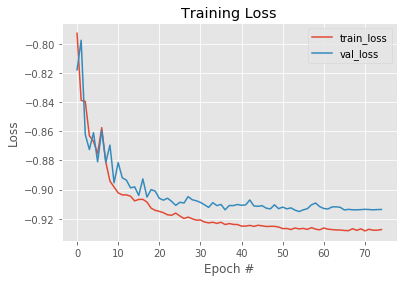

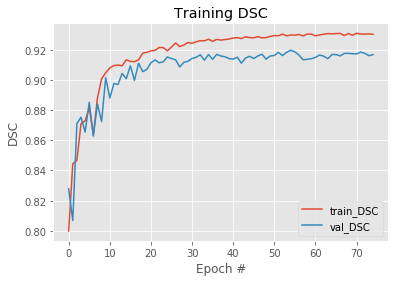

In [22]:
# Step 7: Print Output
# plot the training + testing loss and accuracy
Fepochs = len(H.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, Fepochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, Fepochs), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
figpath_final = os.path.join(config['output_dir'], config['input_type'] + "_loss.png")
plt.savefig(figpath_final)
if config['show_plots']:
    plt.show()

plt.figure()
plt.plot(np.arange(0, Fepochs), H.history["dice_coefficient_monitor"], label="train_DSC")
plt.plot(np.arange(0, Fepochs), H.history["val_dice_coefficient_monitor"], label="val_DSC")
plt.title("Training DSC")
plt.xlabel("Epoch #")
plt.ylabel("DSC")
plt.legend()
figpath_final = os.path.join(config['output_dir'], config["input_type"] + '_DSC.png')
plt.savefig(figpath_final)
if config['show_plots']:
    plt.show()